# Fine-tuning BERT (and friends) for multi-label text classification

In this notebook, we are going to fine-tune BERT to predict one or more labels for a given piece of text. Note that this notebook illustrates how to fine-tune a bert-base-uncased model, but you can also fine-tune a RoBERTa, DeBERTa, DistilBERT, CANINE, ... checkpoint in the same way.

All of those work in the same way: they add a linear layer on top of the base model, which is used to produce a tensor of shape (batch_size, num_labels), indicating the unnormalized scores for a number of labels for every example in the batch.



## Set-up environment

First, we install the libraries which we'll use: HuggingFace Transformers and Datasets.

In [438]:
!pip install -q transformers datasets

## Load dataset

Next, let's download a multi-label text classification dataset from the [hub](https://huggingface.co/).

At the time of writing, I picked a random one as follows:   

* first, go to the "datasets" tab on huggingface.co
* next, select the "multi-label-classification" tag on the left as well as the the "1k<10k" tag (fo find a relatively small dataset).

Note that you can also easily load your local data (i.e. csv files, txt files, Parquet files, JSON, ...) as explained [here](https://huggingface.co/docs/datasets/loading.html#local-and-remote-files).



In [439]:
# !pip install pyarrow==0.17.1

import pandas as pd
from datasets import Dataset

In [440]:
data_file= '/content/RRAVIPRA_train_final_.25%.csv'
df_train = pd.read_csv(data_file)

data_file= '/content/RRAVIPRA_test_final_.25%.csv'
df_test = pd.read_csv(data_file)

data_file= '/content/RRAVIPRA_val_final_.25%.csv'
df_val = pd.read_csv(data_file)

print("train len: ",len(df_train))
print("test len: ",len(df_test))
print("val len: ",len(df_val))

train len:  283685
test len:  60791
val len:  60791


In [441]:
#TESTER
# df_train = df_train.iloc[:15000,:]
# df_test = df_test.iloc[:1500,:]
# df_val = df_val.iloc[:1500,:]

In [442]:
# #synthetic data
# import pandas as pd
# from datasets import Dataset
# data_file= '/content/RRAVIPRA_train_final_.25%.csv'

# df = pd.read_csv(data_file)
# display(df.head())
# # rename the columns
# # df = df[['toxicity','text']]
# # df.rename(columns={'toxicity':'label', 'text':'message'}, inplace=True)
# # df_new = balance_dataset(df)
# print(df.head())
# df = df.reset_index(drop=True)
# display(df.head())
# # dataset = Dataset.from_pandas(df)

In [443]:
# Check the distribution of labels in the balanced DataFrame
label_distribution = df_train['label'].value_counts()

# Display the label distribution
print(label_distribution)

0    282964
1       721
Name: label, dtype: int64


In [444]:
# !pip install -U imbalanced-learn


In [445]:
#Testing out baalcned dataset
# print(len(df))

In [446]:
# import pandas as pd
# from imblearn.under_sampling import RandomUnderSampler


# # Separate features and labels
# X = df[['message']]
# y = df['label']

# # Create an undersampler
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# # Fit and transform the data to create a balanced DataFrame
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# # Create a new DataFrame with the balanced data
# balanced_df = pd.DataFrame({'message': X_resampled['message'], 'label': y_resampled})

# # Check the distribution of labels in the balanced DataFrame
# label_distribution = balanced_df['label'].value_counts()

# # Display the label distribution
# print(label_distribution)
# df = balanced_df.copy()

In [447]:
# label_distribution = df['label'].value_counts()

# # Display the label distribution
# print(label_distribution)

In [448]:
# print(len(df))
# shuffled_df = df.sample(frac=1, random_state=42)  # Set a random_state for reproducibility
# shuffled_df = shuffled_df.dropna()
# print(len(shuffled_df))
# # Extract 3765 rows
# # df_synthetic = shuffled_df.head(3765)
# # len(df_synthetic)
# df=shuffled_df.copy()

In [449]:

# df_synthetic=df_synthetic.reset_index(drop=True)
# df_synthetic.head()

In [450]:
# df_synthetic['label'] = df_synthetic['label'].fillna(0)
# print("print",df_synthetic.dtypes)
# df_synthetic['label'] = df_synthetic['label'].astype(int)

In [451]:
# #original dataset
# import pandas as pd
# from datasets import Dataset
# data_file= '/content/combined_dataset.csv'

# df = pd.read_csv(data_file)
# # rename the columns
# df = df[['toxicity','text']]
# df.rename(columns={'toxicity':'label', 'text':'message'}, inplace=True)
# # df_new = balance_dataset(df)
# # print(df.head())
# df = df.reset_index(drop=True)
# display(df.head())

# shuffled_df_orig = df.sample(frac=1, random_state=42)

# # Extract 151130 rows -> val + test set (30%)
# df_test_val = shuffled_df_orig.head(151130)
# print("len of df_test_val: ",len(df_test_val))
# # dataset = Dataset.from_pandas(df)

# # Remaining rows for the training set
# df_train = shuffled_df_orig[~shuffled_df_orig.index.isin(df_test_val.index)]

# # Save the remaining rows in a DataFrame called df_train
# df_train.reset_index(drop=True, inplace=True)
# print("len of df_train: ",len(df_train))

In [452]:
# df_train=df_train.reset_index(drop=True)
# df_test_val=df_test_val.reset_index(drop=True)

# display(df_train.head())
# print(df_train.dtypes)
# print(df_test_val.dtypes)
# display(df_test_val.head())

In [453]:
# #Union of the two
# union_df_train = pd.concat([df_train, df_synthetic], ignore_index=True)
# union_df_train = union_df_train.sample(frac=1, random_state=42)

In [454]:
# len(union_df_train)

In [455]:
# from sklearn.model_selection import train_test_split
# train_df, val_df = train_test_split(df, test_size=0.2)
# test_df, val_df = train_test_split(val_df, test_size=0.5)
# # train_df=union_df_train

In [456]:
# test_df.to_csv('AB_test_1%.csv')
# val_df.to_csv('AB_val_1%.csv')
# train_df.to_csv('AB_train_1%.csv')

In [457]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Assuming df is your full DataFrame
# train_df, test_df = train_test_split(df, test_size=0.3)
# # Further split the test dataframe into test and validation
# test_df, val_df = train_test_split(test_df, test_size=0.5)

# Convert the DataFrames into huggingface datasets
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
val_dataset = Dataset.from_pandas(df_val)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': val_dataset
})


In [458]:
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'label'],
        num_rows: 283685
    })
    test: Dataset({
        features: ['message', 'label'],
        num_rows: 60791
    })
    validation: Dataset({
        features: ['message', 'label'],
        num_rows: 60791
    })
})

In [459]:
# from datasets import load_dataset

# dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")

As we can see, the dataset contains 3 splits: one for training, one for validation and one for testing.

In [460]:
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'label'],
        num_rows: 283685
    })
    test: Dataset({
        features: ['message', 'label'],
        num_rows: 60791
    })
    validation: Dataset({
        features: ['message', 'label'],
        num_rows: 60791
    })
})

In [461]:


# dataset=dataset.remove_columns(column_names='__index_level_0__')

# # Print the updated dataset information
# print(dataset)

In [462]:
# Assuming your dataset is named 'dataset'
dataset['train'] = dataset['train'].map(lambda example: {'message': example['message'], 'positive': example['label'] == 1, 'negative': example['label'] == 0})


dataset['validation'] = dataset['validation'].map(lambda example: {'message': example['message'], 'positive': example['label'] == 1, 'negative': example['label'] == 0})
# dataset=dataset.remove_columns(column_names='label')

dataset['test'] = dataset['test'].map(lambda example: {'message': example['message'], 'positive': example['label'] == 1, 'negative': example['label'] == 0})
# dataset=dataset.remove_columns(column_names='label')
dataset=dataset.remove_columns(column_names='label')
# Check the modified dataset
print(dataset)


Map:   0%|          | 0/283685 [00:00<?, ? examples/s]

Map:   0%|          | 0/60791 [00:00<?, ? examples/s]

Map:   0%|          | 0/60791 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['message', 'positive', 'negative'],
        num_rows: 283685
    })
    test: Dataset({
        features: ['message', 'positive', 'negative'],
        num_rows: 60791
    })
    validation: Dataset({
        features: ['message', 'positive', 'negative'],
        num_rows: 60791
    })
})



Let's check the first example of the training split:

In [463]:
example = dataset['train'][0]
example

{'message': "She's what's commonly eager to as a lost cause. Don't waste your breath. Move",
 'positive': False,
 'negative': True}

The dataset consists of tweets, labeled with one or more emotions.

Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [464]:
# # Assuming your dataset is a list of dictionaries and each dictionary has a 'your_label_column' key
# unique_labels = set(example['label'] for example in dataset['train'])
# print("Unique Labels:", unique_labels)


In [465]:
#Positive = True; Means HOT
example = dataset['train'][1]
example

{'message': '**Spoiler Warning:** All officially-released show and book content allowed, including trailers and pre-released chapters. No leaked information or paparazzi photos of the set. For more info please check the [spoiler guide](/r/gameofthrones/w/spoiler_guide).\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/gameofthrones) if you have any questions or concerns.*',
 'positive': False,
 'negative': True}

In [466]:
labels = [label for label in dataset['train'].features.keys() if label not in ['message']]
# id2label = {idx:label for idx, label in enumerate(labels)}
# label2id = {label:idx for idx, label in enumerate(labels)}
# print(labels)
#TESTTT
labels = ['negative', 'positive']

# Create id2label mapping
id2label = {idx: label for idx, label in enumerate(labels)}

# Create label2id mapping
label2id = {label: idx for idx, label in enumerate(labels)}

# Manually set the mapping for 'positive' to 1 and 'negative' to 0
label2id['positive'] = 1
label2id['negative'] = 0

print("id2label:", id2label)
print("label2id:", label2id)

id2label: {0: 'negative', 1: 'positive'}
label2id: {'negative': 0, 'positive': 1}


## Preprocess data

As models like BERT don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

What's a bit tricky is that we also need to provide labels to the model. For multi-label text classification, this is a matrix of shape (batch_size, num_labels). Also important: this should be a tensor of floats rather than integers, otherwise PyTorch' `BCEWithLogitsLoss` (which the model will use) will complain, as explained [here](https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3).

In [467]:
#pip list | grep jax

In [468]:
#!pip install -U jax jaxlib

In [469]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["message"]
  # display(text)
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # print("labels_batch: ",labels_batch)
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    print("idx: ",idx, "label: ", label)
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding

In [470]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/283685 [00:00<?, ? examples/s]

idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive


Map:   0%|          | 0/60791 [00:00<?, ? examples/s]

idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive


Map:   0%|          | 0/60791 [00:00<?, ? examples/s]

idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive
idx:  0 label:  negative
idx:  1 label:  positive


In [471]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [472]:
tokenizer.decode(example['input_ids'])

"[CLS] she's what's commonly eager to as a lost cause. don't waste your breath. move [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [473]:
example['labels']

[1.0, 0.0]

In [474]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 0.0]

['positive']

Finally, we set the format of our data to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch [datasets](https://pytorch.org/docs/stable/data.html).

In [475]:
encoded_dataset.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base (i.e. the weights from bert-base-uncased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

This is also printed by the warning.

We set the `problem_type` to be "multi_label_classification", as this will make sure the appropriate loss function is used (namely [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)). We also make sure the output layer has `len(labels)` output neurons, and we set the id2label and label2id mappings.

In [476]:
from transformers import AutoModelForSequenceClassification
print(len(labels))

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train the model!

We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things:

* `TrainingArguments`, which specify training hyperparameters. All options can be found in the [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size to use for training/evaluation, how many epochs to train for, and so on.
* a `Trainer` object (docs can be found [here](https://huggingface.co/transformers/main_classes/trainer.html#id1)).

In [477]:
batch_size = 16
metric_name = "f1"

In [478]:
# !pip install accelerate -U

In [479]:
# !pip install transformers[torch]

In [480]:
!pip show transformers
!pip show accelerate


Name: transformers
Version: 4.37.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Name: accelerate
Version: 0.22.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, packaging, psutil, pyyaml, torch
Required-by: 


In [481]:
import accelerate

accelerate.__version__

'0.22.0'

In [482]:
# !pip install accelerate -U
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    # gradient_accumulation_steps=2,
    logging_strategy = "epoch",
    logging_steps = 0.1
    #push_to_hub=True,
)

In [483]:
# !pip show accelerate


We are also going to compute metrics while training. For this, we need to define a `compute_metrics` function, that returns a dictionary with the desired metric values.

In [484]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, multilabel_confusion_matrix, classification_report
from transformers import EvalPrediction
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    y_pred = y_pred[:, 1]
    labels = np.array(labels)[:, 1]
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Print the confusion matrix to understand class distribution
    # confusion_mat = confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy())

    cm =  multilabel_confusion_matrix(labels, y_pred)
    print(cm[1])

    # Visualize confusion matrix using Seaborn
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.title('Confusion Matrix')
    # plt.show()

    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'precision': precision,
               'recall': recall}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

Let's verify a batch as well as a forward pass:

In [485]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [486]:
encoded_dataset['train']['input_ids'][0]

tensor([ 101, 2016, 1005, 1055, 2054, 1005, 1055, 4141, 9461, 2000, 2004, 1037,
        2439, 3426, 1012, 2123, 1005, 1056, 5949, 2115, 3052, 1012, 2693,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [487]:
#forward pass

outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0),attention_mask=encoded_dataset['train']['attention_mask'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.9170, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.5582,  0.2452]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Let's start training!

In [488]:
# del trainer
import os
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:100'

In [489]:
from accelerate import Accelerator

In [490]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [491]:
# import os

# Set environment variable for PyTorch CUDA allocator configuration
# Adjust max_split_size_mb to an appropriate value for your system
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:50'

# !pip install torch==2.0.0



In [492]:
# Example: Handling scalar tensor
scalar_tensor = torch.tensor(42)  # Replace with your actual tensor
scalar_tensor = scalar_tensor.unsqueeze(0)  # Unsqueezing to create a one-dimensional tensor
print(scalar_tensor)

tensor([42])


In [493]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.014400,0.010296,0.617391,0.728999,0.998552,0.946667,0.458065
2,0.010500,0.008698,0.669291,0.774078,0.998618,0.858586,0.548387
3,0.007600,0.008515,0.641026,0.741903,0.998618,0.949367,0.483871


[[60632     4]
 [   84    71]]


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[[60622    14]
 [   70    85]]


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[[60632     4]
 [   80    75]]


TrainOutput(global_step=26598, training_loss=0.010845226778626595, metrics={'train_runtime': 25173.5279, 'train_samples_per_second': 33.808, 'train_steps_per_second': 1.057, 'total_flos': 2.239219792194048e+17, 'train_loss': 0.010845226778626595, 'epoch': 3.0})

In [494]:
# eval_results = trainer.evaluate()
# # Access confusion matrix from evaluation results
# confusion_matrix_result = eval_results['confusion_mat']
# print("Confusion Matrix:")
# print(confusion_matrix_result)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[[60618    18]
 [   70    85]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60636
           1       0.83      0.55      0.66       155

   micro avg       1.00      1.00      1.00     60791
   macro avg       0.91      0.77      0.83     60791
weighted avg       1.00      1.00      1.00     60791
 samples avg       1.00      1.00      1.00     60791



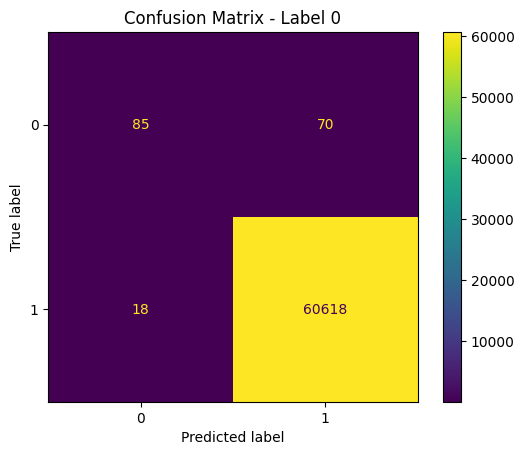

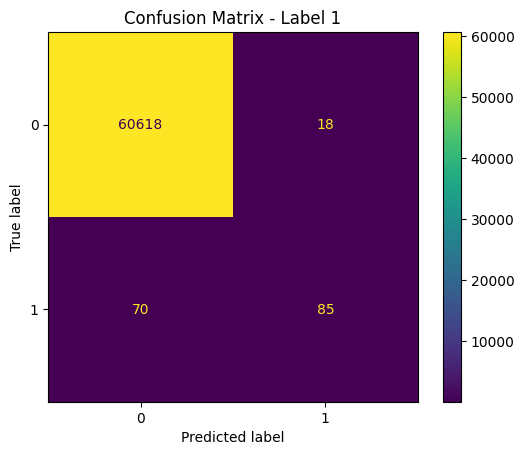

In [495]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

# Define your Trainer and TrainingArguments
# ...

# Evaluate the model on your test dataset
results = trainer.predict(encoded_dataset["test"])

# Get true labels and predicted probabilities
true_labels = results.label_ids
predicted_probs = torch.nn.Softmax(dim=1)(torch.Tensor(results.predictions))

# Apply a threshold to convert probabilities to binary predictions
threshold = 0.5
predicted_labels = (predicted_probs >= threshold).int()

# Calculate multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels))

# Display the confusion matrix for each label separately
for i, mat in enumerate(conf_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=mat)
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f'Confusion Matrix - Label {i}')
    plt.show()


In [496]:
# print(true_labels)

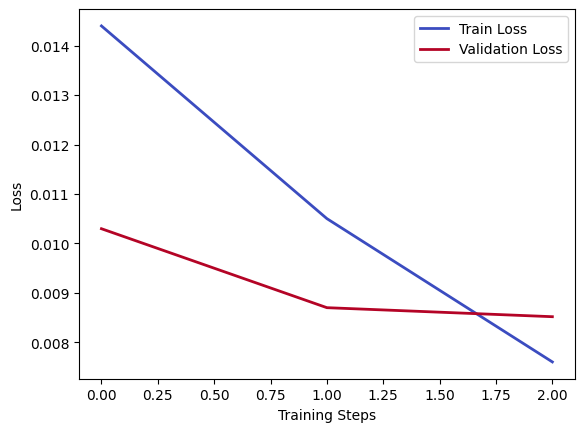

In [497]:
train_logs = trainer.state.log_history

# Extract training and validation losses
train_losses = [log['loss'] for log in train_logs if 'loss' in log and 'eval_loss' not in log]
eval_losses = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]

# Generate a gradient of colors
gradient = np.linspace(0, 1, len(train_losses))

# Plot the training and validation loss with a gradient
plt.plot(train_losses, label="Train Loss", color=plt.cm.coolwarm(gradient[0]), linewidth=2)
plt.plot(eval_losses, label="Validation Loss", color=plt.cm.coolwarm(gradient[-1]), linewidth=2)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()

# Show the plot
plt.show()

## Evaluate

After training, we evaluate our model on the validation set.

In [498]:
#Overfitting above

In [499]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[[60622    14]
 [   70    85]]


{'eval_loss': 0.00869782641530037,
 'eval_f1': 0.6692913385826771,
 'eval_roc_auc': 0.7740781054159246,
 'eval_accuracy': 0.9986182165123126,
 'eval_precision': 0.8585858585858586,
 'eval_recall': 0.5483870967741935,
 'eval_runtime': 624.4885,
 'eval_samples_per_second': 97.345,
 'eval_steps_per_second': 3.042,
 'epoch': 3.0}

## Inference

Let's test the model on a new sentence:

In [500]:
text = "Fuck you"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

The logits that come out of the model are of shape (batch_size, num_labels). As we are only forwarding a single sentence through the model, the `batch_size` equals 1. The logits is a tensor that contains the (unnormalized) scores for every individual label.

In [501]:
logits = outputs.logits
logits.shape

torch.Size([1, 2])

To turn them into actual predicted labels, we first apply a sigmoid function independently to every score, such that every score is turned into a number between 0 and 1, that can be interpreted as a "probability" for how certain the model is that a given class belongs to the input text.

Next, we use a threshold (typically, 0.5) to turn every probability into either a 1 (which means, we predict the label for the given example) or a 0 (which means, we don't predict the label for the given example).

In [502]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
print(predictions.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 0.0]
print(predicted_labels)

(2,)
['positive']


In [503]:
trainer.predict(encoded_dataset["test"])

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[[60618    18]
 [   70    85]]


PredictionOutput(predictions=array([[ 6.782035 , -6.8324304],
       [ 7.318239 , -7.348715 ],
       [ 6.7939553, -6.8453684],
       ...,
       [ 7.5125327, -7.487436 ],
       [ 7.3788104, -7.3943577],
       [ 7.1923995, -7.243364 ]], dtype=float32), label_ids=array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32), metrics={'test_loss': 0.008530281484127045, 'test_f1': 0.6589147286821705, 'test_roc_auc': 0.7740451217098753, 'test_accuracy': 0.9985524172986133, 'test_precision': 0.8252427184466019, 'test_recall': 0.5483870967741935, 'test_runtime': 624.3738, 'test_samples_per_second': 97.363, 'test_steps_per_second': 3.043})

In [504]:
#high test cz most are zeroes and would ve assigned the same i presume?